In [1]:
%matplotlib inline

In [2]:
import numpy as np
import os
import time

In [3]:
import matplotlib
import matplotlib.pyplot as plt

In [4]:
def plot_seg(seg, border=False):
    unique, unique_inverse = np.unique(seg, return_inverse=True)
    N = len(unique)
    cmap = np.random.rand(N,3)
    if border:
        cmap[0,:] = 0
    cmap = matplotlib.colors.ListedColormap(cmap)
    plt.imshow(np.arange(N)[unique_inverse].reshape(seg.shape), cmap=cmap)

In [5]:
import evaluator

In [6]:
from types import SimpleNamespace

In [37]:
import datatools

## AC3-test ground truth

In [38]:
d = dict()
d['gs_input'] = 'gs://neuroglancer/kisuk/kasthuri11/AC3/ground_truth/v3.0.3/z156-256/crop_x0_y0_z0/segm0'
d['dtype'] = 'uint32'
d['in_mip']   = 1
d['begin']   = (0,0,156) 
d['end']     = None
d['center']  = None
d['size']    = (1024,1024,100)
d['cache']   = True
d['parallel'] = 8
gt_opt = SimpleNamespace(**d)

In [39]:
%%capture
gt = evaluator.cutout(gt_opt, dtype=gt_opt.dtype)

In [40]:
gt = np.asarray(gt)
print(gt.shape)

(100, 512, 512)


## Myelin

In [41]:
d['gs_input'] = 'gs://neuroglancer/kisuk/kasthuri11/AC3/ground_truth/mye'
d['dtype'] = 'uint8'
mye_opt = SimpleNamespace(**d)

In [42]:
%%capture
mye = evaluator.cutout(mye_opt, dtype=mye_opt.dtype)

In [43]:
mye = np.asarray(mye)
print(mye.shape)

(100, 512, 512)


## segm0

In [44]:
gt[mye==1] = 0

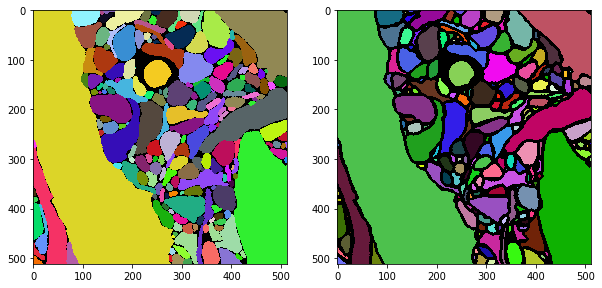

In [45]:
# Recompute connected components and create border mask (2 pxl).
z = 10
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plot_seg(gt[z,:,:], border=True)

gt_b2 = np.copy(gt)
evaluator.create_border_mask(gt, gt_b2, 2)

plt.subplot(1,2,2)
plot_seg(gt_b2[z,:,:], border=True)
plt.show()

## Misalign10 (bdr = 0.7)

In [12]:
data_id = 'AC3'
iternum = 500000
gs_path = 'gs://neuroglancer/kisuk/kasthuri11/{}/experiments/kasthuri11/new/train216_val40_test100/mip1/seg-m1_bdr-m0/metric/mean/mip1/depth3_width32_patch128-20_crop96-16_bn/vec24/vec1_bdr1/misalign10/iter_{}/mip1/fov128-20/crop96-16/overlap50/precomputed/'.format(data_id, iternum)
print(gs_path)

gs://neuroglancer/kisuk/kasthuri11/AC3/experiments/kasthuri11/new/train216_val40_test100/mip1/seg-m1_bdr-m0/metric/mean/mip1/depth3_width32_patch128-20_crop96-16_bn/vec24/vec1_bdr1/misalign10/iter_500000/mip1/fov128-20/crop96-16/overlap50/precomputed/


In [13]:
d = dict()
d['gs_input'] = gs_path + 'test/bug_fixed/mws-seg_bdr70_stride2_dust150'
d['dtype']   = 'uint32'
d['in_mip']   = 0
d['begin']   = (0,0,156) 
d['end']     = None
d['center']  = None
d['size']    = (512,512,100)
d['cache']   = True
d['parallel'] = 8
seg_opt = SimpleNamespace(**d)

In [14]:
%%capture
seg = evaluator.cutout(seg_opt, dtype=seg_opt.dtype)

In [15]:
seg = np.asarray(seg)
print(seg.shape)

(100, 512, 512)


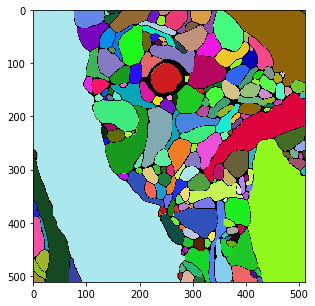

In [31]:
z = 10
plt.figure(figsize=(5,5))
plot_seg(seg[z,...], border=True)
plt.show()

## Dust filtering

In [16]:
dust_size = 150

In [17]:
unq, cnt = np.unique(seg, return_counts=True)
dust_ids = unq[cnt < dust_size]
dust_idx = np.isin(seg, dust_ids)
filtered = np.copy(seg)
filtered[dust_idx] = 0

print("Before dust filtering: {}".format(len(unq)))
print("After dust filtering: {}".format(len(unq) - len(dust_ids)))

Before dust filtering: 11151
After dust filtering: 432


## Evaluation

In [46]:
dilated = datatools.dilate_segmentation(filtered.astype('uint32'), k=512).astype('uint32')

In [47]:
pxy, px, py, hxgy, hygx, lpygx, lpxgy = evaluator.vi_tables(dilated, gt_b2, ignore_x=[], ignore_y=[0])

In [49]:
hxgy.sum() + hygx.sum()

0.11175847032652653

In [51]:
result = evaluator.voi(dilated, gt_b2)
print("After dust filtering")
print("VI sum   = {:.5f}".format(sum(result)))
print("VI split = {:.5f}".format(result[0]))
print("VI merge = {:.5f}".format(result[1]))

After dust filtering
VI sum   = 0.11176
VI split = 0.09578
VI merge = 0.01598
